In [19]:
import numpy as np
import matplotlib.pyplot as plt


In [40]:
nens = 20
nlobs = 2

##prior state is a random variable
np.random.seed(1)
xb = np.random.normal(0, 0.3, nens)

##obs
yo = np.zeros(nlobs)
yo[0] = 0.8
yo[1] = 0.5

obs_err = 0.2

##obs prior
yb = np.zeros((nlobs, nens))
yb[0, :] = 0.5 + 0.5*xb + 0.5*np.random.normal(0, 0.3, nens)
yb[1, :] = 0.5 - 0.5*xb + 0.5*np.random.normal(0, 0.3, nens)

xb_mean = np.mean(xb)
xb_pert = xb - xb_mean

yb_mean = np.mean(yb, axis=1)
yb_pert = yb - np.tile(yb_mean, (nens, 1)).T
innov = yo - yb_mean

##localization function for nlobs
loc_func = np.array([.8, .5])


In [41]:
##EnSRF, identical to EAKF

x = xb.copy()
y = yb.copy()

x_mean = np.mean(x)
x_pert = x - np.tile(x_mean, (nens, 1)).T
y_mean = np.mean(y, axis=1)
y_pert = y - np.tile(y_mean, (nens, 1)).T

for p in range(nlobs):
    obs = yo[p]
    obs_prior = y_pert[p,:] + y_mean[p]
    obs_prior_mean = np.mean(obs_prior)
    obs_prior_pert = obs_prior - obs_prior_mean
    varo = obs_err**2
    varb = np.sum(obs_prior_pert**2)/(nens-1)
    srf = 1. / (1. + np.sqrt(varo / (varo + varb)))

    cov = np.sum(x_pert*obs_prior_pert)/(nens-1)
    x_mean = x_mean + loc_func[p] * cov / (varo + varb) * (obs - obs_prior_mean)
    x_pert = x_pert - srf * loc_func[p] * cov / (varo + varb) * obs_prior_pert

    for q in range(nlobs):
        cov = np.sum(y_pert[q,:]*obs_prior_pert)/(nens-1)
        y_mean[q] = y_mean[q] + loc_func[p] * cov / (varo + varb) * (obs - obs_prior_mean)
        y_pert[q,:] = y_pert[q,:] - srf * loc_func[p] * cov / (varo + varb) * obs_prior_pert

xa = x_mean + x_pert
ya = np.tile(y_mean, (nens,1)).T + y_pert


In [42]:
##EAKF

x = xb.copy()
y = yb.copy()

for p in range(nlobs):
    obs = yo[p]
    obs_prior = y[p,:]
    obs_prior_mean = np.mean(obs_prior)
    obs_prior_pert = obs_prior - obs_prior_mean
    varo = obs_err**2
    varb = np.sum(obs_prior_pert**2)/(nens-1)
    var_ratio = varo / (varo + varb)

    obs_post_mean = obs_prior_mean * var_ratio + obs * (1-var_ratio)
    obs_incr = np.sqrt(var_ratio) * obs_prior_pert + obs_post_mean - obs_prior

    cov = np.sum(x*obs_prior_pert)/(nens-1)
    x = x + loc_func[p] * cov / varb * obs_incr
    for q in range(nlobs):
        cov = np.sum(y[q,:]*obs_prior_pert)/(nens-1)
        y[q] = y[q] + loc_func[p] * cov / varb * obs_incr
        
xa1 = x
ya1 = y

In [43]:
##ETKF

S = np.zeros((nlobs, nens))
dy = np.zeros((nlobs))

W = np.zeros((nens, nens))

for p in range(nlobs):
    S[p, :] = yb_pert[p,:] * loc_func[p] / obs_err / np.sqrt(nens-1)
    dy[p] = innov[p] * loc_func[p] / obs_err / np.sqrt(nens-1)

V = np.eye(nens) + S.T @ S
L,e,Rh = np.linalg.svd(V)
Vinv = L @ np.diag(e**-1) @ Rh

G = Vinv @ S.T

##part of the weights will update the mean using innovation dy
for m in range(nens):
    W[m, :] = np.sum(G[m,:] * dy)

##this is the ETKF adjustment to posterior variance (I + S^T S)^-1/2
W += L @ np.diag(e**-0.5) @ Rh
## the DEnKF approx. is
#W += np.eye(nens) - 0.5 * G @ S

xa2 = xb @ W
ya2 = yb @ W


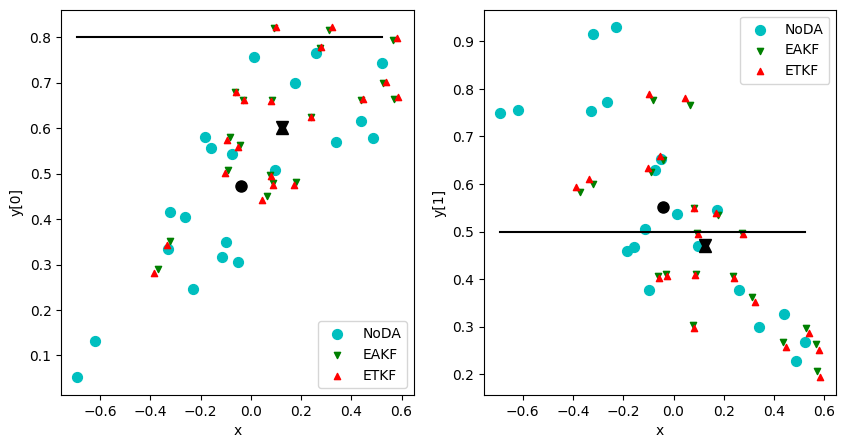

In [44]:
fig, ax = plt.subplots(1, nlobs, figsize=(10,5))

for i in range(nlobs):
    ax[i].scatter(xb, yb[i,:], 50, color='c', marker='o', label='NoDA')
    ax[i].plot([xb.min(), xb.max()], [yo[i], yo[i]], 'k')
    ax[i].scatter(xa1, ya1[i,:], 20, color='g', marker='v', label='EAKF')
    ax[i].scatter(xa2, ya2[i,:], 20, color='r', marker='^', label='ETKF')
    ax[i].plot(np.mean(xb), np.mean(yb[i,:]), 'ko', markersize=8)
    ax[i].plot(np.mean(xa1), np.mean(ya1[i,:]), 'kv', markersize=8)
    ax[i].plot(np.mean(xa2), np.mean(ya2[i,:]), 'k^', markersize=8)
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y[{}]'.format(i))
    ax[i].legend()



In [45]:
xa1, xa2, np.mean(xa1), np.mean(xa2)

(array([ 0.57072927, -0.06367865, -0.03026054, -0.0810362 ,  0.31261495,
        -0.37024458,  0.56507758,  0.06408989,  0.2384875 ,  0.08337977,
         0.52690252, -0.31991302,  0.07762127,  0.08918161,  0.43755631,
        -0.09118427,  0.1786681 , -0.04217762,  0.09376354,  0.27385974]),
 array([ 0.58394821, -0.05906138, -0.02642342, -0.09664717,  0.32381735,
        -0.38667353,  0.58000381,  0.04468252,  0.24127983,  0.0808685 ,
         0.5371702 , -0.33505647,  0.0808253 ,  0.08696181,  0.4479457 ,
        -0.10231946,  0.17080215, -0.05264181,  0.09885362,  0.27752865]),
 0.12567185880638684,
 0.12479322098338604)

1.0000000000000004
1.0000000000000002
0.999999999999999
1.0000000000000002
1.0000000000000009
1.0000000000000002
0.9999999999999992
0.9999999999999997
0.9999999999999994
0.9999999999999997
1.0
1.0000000000000009
1.0000000000000002
1.0000000000000007
0.9999999999999992
1.0000000000000007
0.9999999999999999
0.9999999999999996
0.9999999999999996
1.0


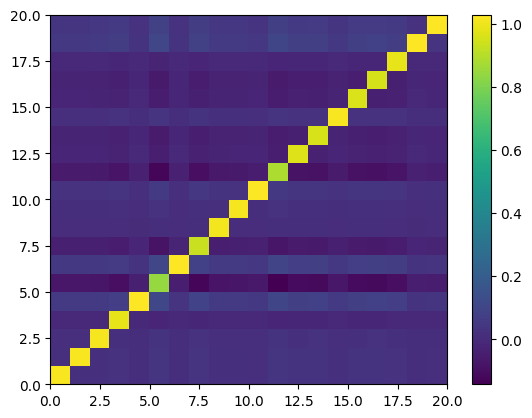

In [32]:
im = plt.pcolor(W.real)
plt.colorbar(im)
for m in range(nens):
    print(np.sum(W[:, m]))